<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Модель-SGDClassifier" data-toc-modified-id="Модель-SGDClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель SGDClassifier</a></span></li><li><span><a href="#Модель-LinearSVC" data-toc-modified-id="Модель-LinearSVC-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель LinearSVC</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
tox = data['toxic'].value_counts()
print(tox)

0    143346
1     16225
Name: toxic, dtype: int64


In [5]:
data = data.sample(frac=0.2).reset_index(drop=True)

tox = data['toxic'].value_counts()
print(tox)

0    28773
1     3141
Name: toxic, dtype: int64


Данных много, однако классы несбалансированы. Уравнивать классы буду техникой downsampling.

In [6]:
comm_pos = data[data['toxic'] == 0]
comm_tox = data[data['toxic'] == 1]
data_sample = resample(comm_pos, replace=False, n_samples=tox[1], random_state=12345)
data_new = pd.concat([data_sample, comm_tox])
print(data_new['toxic'].value_counts())

0    3141
1    3141
Name: toxic, dtype: int64


Классы уравнены. Напишу функцию для лемматизации текста и функцию для очистки текста от лишних символов

In [7]:
lemma = WordNetLemmatizer()
def clear(text): 
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = clear_text.split()
    clear_text = " ".join(clear_text)
    return clear_text

def lemm_text(text):
    word_list = nltk.word_tokenize(text)
    lemma_text = ' '.join([lemma.lemmatize(w) for w in word_list])
    return lemma_text

In [8]:
data_new['text'] = data_new['text'].apply(clear)
data_new['lemm_text'] = data_new['text'].apply(lemm_text)
data_new = data_new.drop(['text'], axis=1)
display(data_new.head(3))

,toxic,lemm_text
20323,0,GT Pro Series GT Cube is a separate game in ma...
21458,0,Any comment Yeah Buh bye
31490,0,User Nasrallah block Probable sockpuppet Dec UTC


Выделение целевого признака и разделение данных на обучающую (корпус) и тестовую выборки

In [9]:
features = data_new['lemm_text']
target = data_new['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, \
                                                                            test_size=0.25, random_state = 54321)

Для обучения моделей нужны признаки, создам их с помощью вычисления TF-IDF

In [10]:
n_stopwords = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=n_stopwords)
count_tf_idf.fit(features_train)
features_train = count_tf_idf.fit_transform(features_train).toarray()
features_test = count_tf_idf.transform(features_test).toarray()

Удаление больших и уже ненужных датафреймов

In [11]:
del data
del data_sample
del comm_pos
del data_new 

## Обучение

In [12]:
f1_metric = {}

### Логистическая регрессия

In [13]:


model_logist = LogisticRegression(solver='liblinear', random_state=12345)
model_logist = model_logist.fit(features_train, target_train)

predictions_train = model_logist.predict(features_train)
f1_train_logist = f1_score(target_train, predictions_train)
print('Метрика F1 на обучающей выборке:', f1_train_logist)

Метрика F1 на обучающей выборке: 0.9466268146883007


In [14]:
predictions_test = model_logist.predict(features_test)
f1_test_logist = f1_score(target_test, predictions_test)
print('Метрика F1 на тестовой выборке:', f1_test_logist)

Метрика F1 на тестовой выборке: 0.8655913978494625


In [15]:
f1_metric['LogisticRegression'] = [f1_train_logist, f1_test_logist]

### Модель SGDClassifier

In [16]:
model_sgd = SGDClassifier(shuffle=True, random_state=42)
model_sgd.fit(features_train, target_train)
predictions = model_sgd.predict(features_train)
f1_train_sgd = f1_score(target_train, predictions)
print('Метрика F1 на обучающей выборке:', f1_train_sgd)

Метрика F1 на обучающей выборке: 0.9949516196886833


In [17]:
predictions_tes = model_sgd.predict(features_test)
f1_test_sgd = f1_score(target_test, predictions_tes)
print('Метрика F1 на тестовой выборке:', f1_test_sgd)

Метрика F1 на тестовой выборке: 0.8654891304347827


In [18]:
f1_metric['SGDClassifier'] = [f1_train_sgd, f1_test_sgd]

### Модель LinearSVC

In [19]:
model_svc = LinearSVC()
model_svc.fit(features_train, target_train)
predictions1 = model_svc.predict(features_train)
f1_train_svc = f1_score(target_train, predictions1)
f1_train_svc

0.9981080512928318

In [20]:
predictions2 = model_svc.predict(features_test)
f1_test_svc = f1_score(target_test, predictions2)
print('Метрика F1 на тестовой выборке:', f1_test_svc)

Метрика F1 на тестовой выборке: 0.8717259905977167


In [21]:
f1_metric['LinearSVC'] = [f1_train_svc, f1_test_svc]

## Выводы

,f1_train,f1_test
LogisticRegression,0.946627,0.865591
SGDClassifier,0.994952,0.865489
LinearSVC,0.998108,0.871726


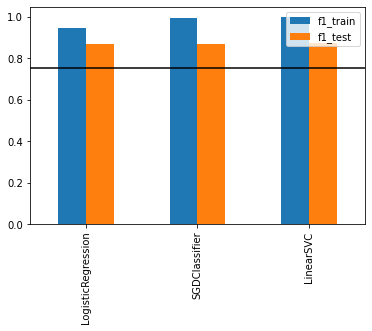

In [22]:
data_f1 = pd.DataFrame.from_dict(data=f1_metric, columns=['f1_train', 'f1_test'], orient='index')
display(data_f1)
data_f1.plot.bar(stacked=False).hlines(0.75, -5, 10, color='k')

- Все три модели показали результат метрики F1 выше порога в 0.75.  
- Лучшее значение метрики F1 на тестовых данных показала модель SGDClassifier.
- Модели LogisticRegression и LinearSVC показали значение незначительно, но меньше.
- Чем больше данных в обучении моделей участвует - тем выше значение их метрик. Если не уменьшать исследуемый датафрейм (я его уменьшал в 5 раз), то модели покажут значение метрики F1 в 0.88-0.90, что не сильно меньше.